In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, Dropdown, IntSlider
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
try:
    df = pd.read_csv("superstore_dataset.csv", encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv("superstore_dataset.csv", encoding='latin-1')


# Basic data exploration
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())

df.info()
df.describe()
df.isnull().sum()

Dataset Shape: (9994, 21)

Column Names:
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [6]:
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())

# Remove duplicates if any
df = df.drop_duplicates()

# Handle missing values (example approach)
print("\nMissing values per column:")
print(df.isnull().sum())

# Example: Fill missing postal codes with 0 or remove rows
if 'Postal Code' in df.columns:
    df['Postal Code'] = df['Postal Code'].fillna(0)

Duplicate rows: 0

Missing values per column:
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


In [7]:
# Convert date columns to datetime
date_columns = ['Order Date', 'Ship Date']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

# Verify the conversion
print("Data types after conversion:")
print(df[date_columns].dtypes)

Data types after conversion:
Order Date    datetime64[ns]
Ship Date     datetime64[ns]
dtype: object


In [8]:
# Feature engineering
df['Profit Margin'] = (df['Profit'] / df['Sales']) * 100
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Month-Year'] = df['Order Date'].dt.to_period('M')

# Display sample of new features
print("New features created:")
print(df[['Sales', 'Profit', 'Profit Margin', 'Order Year', 'Order Month']].head())

New features created:
      Sales    Profit  Profit Margin  Order Year  Order Month
0  261.9600   41.9136          16.00        2016           11
1  731.9400  219.5820          30.00        2016           11
2   14.6200    6.8714          47.00        2016            6
3  957.5775 -383.0310         -40.00        2015           10
4   22.3680    2.5164          11.25        2015           10


In [9]:
# Prepare data for time series analysis
monthly_sales = df.groupby(['Order Month-Year', 'Category'])['Sales'].sum().reset_index()
monthly_sales['Date'] = monthly_sales['Order Month-Year'].dt.to_timestamp()

# Interactive time series plot
def plot_monthly_sales(category='All'):
    plt.figure(figsize=(12, 6))

    if category == 'All':
        # Plot total sales across all categories
        total_monthly = df.groupby('Order Month-Year')['Sales'].sum()
        plt.plot(total_monthly.index.to_timestamp(), total_monthly.values,
                marker='o', linewidth=2, markersize=4)
        plt.title('Monthly Sales Trend - All Categories', fontsize=16, fontweight='bold')
    else:
        # Plot sales for specific category
        category_data = monthly_sales[monthly_sales['Category'] == category]
        plt.plot(category_data['Date'], category_data['Sales'],
                marker='o', linewidth=2, markersize=4)
        plt.title(f'Monthly Sales Trend - {category}', fontsize=16, fontweight='bold')

    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales ($)', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create interactive widget
categories = ['All'] + list(df['Category'].unique())
category_dropdown = Dropdown(options=categories, value='All', description='Category:')
interact(plot_monthly_sales, category=category_dropdown);

interactive(children=(Dropdown(description='Category:', options=('All', 'Furniture', 'Office Supplies', 'Techn…

interactive(children=(IntSlider(value=10, description='Top N States:', max=25, min=5), Output()), _dom_classes…

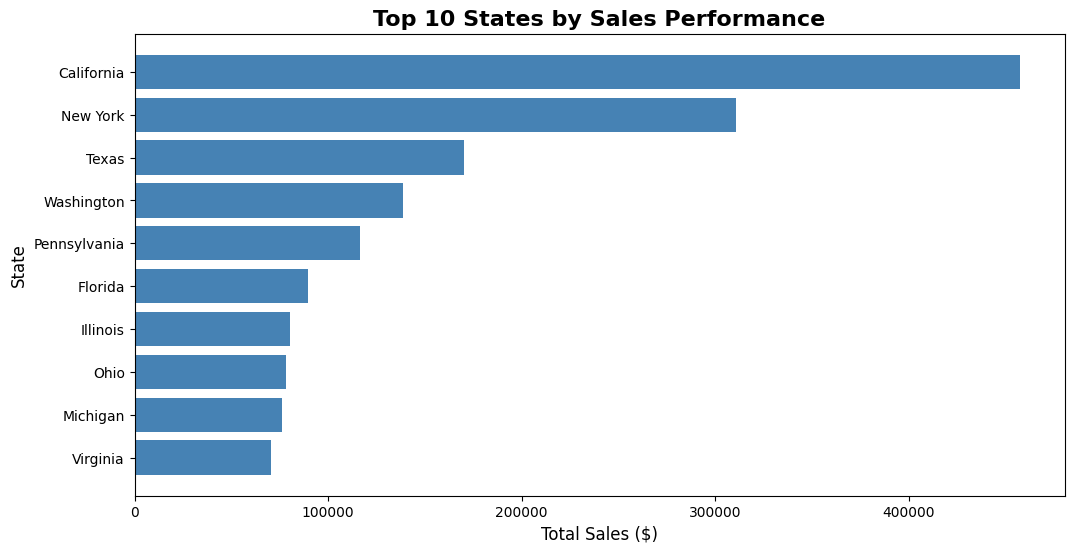

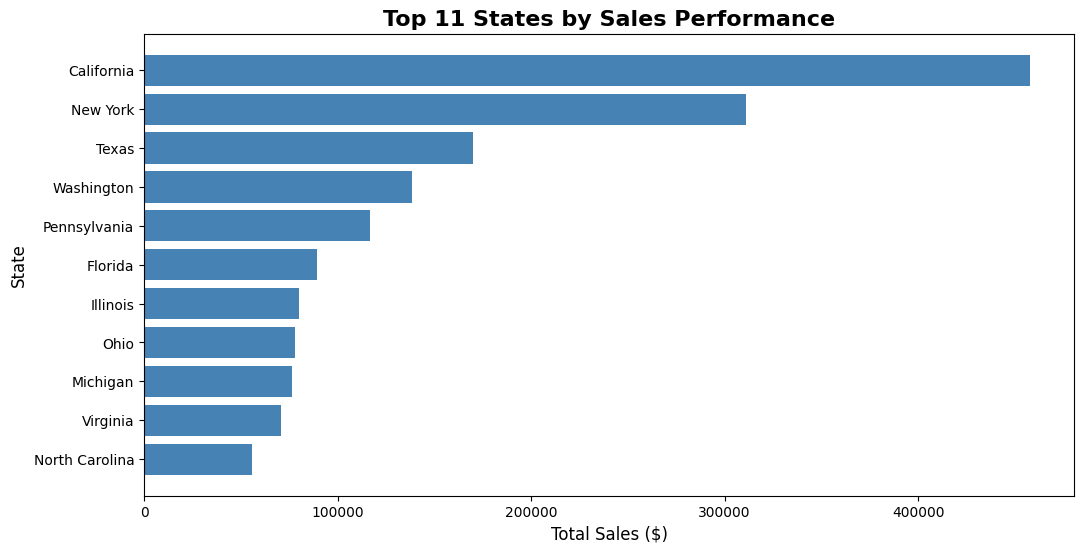

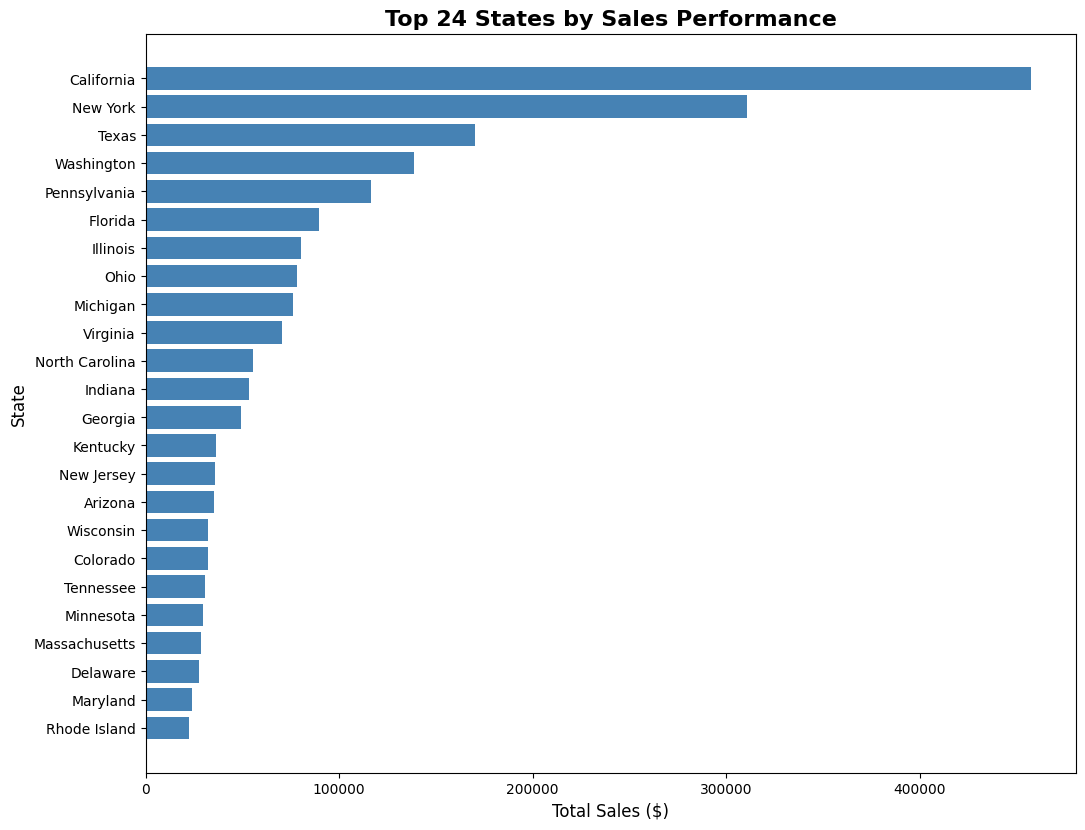

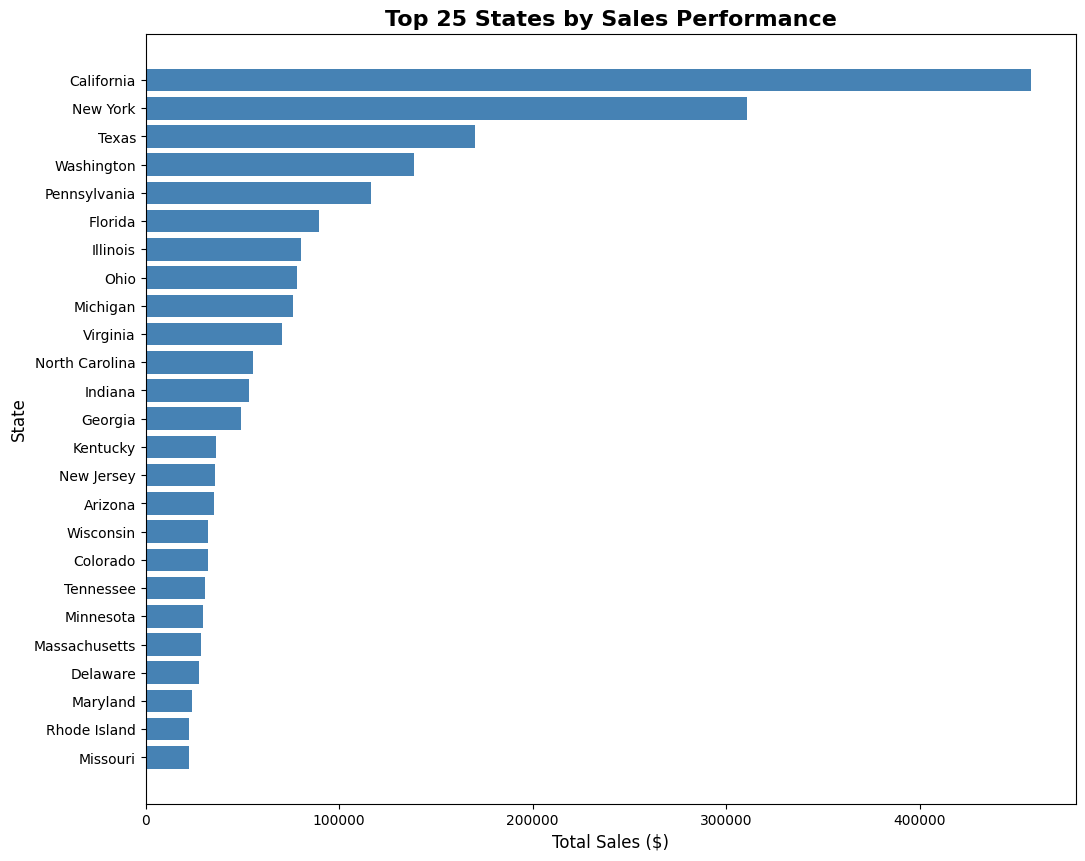

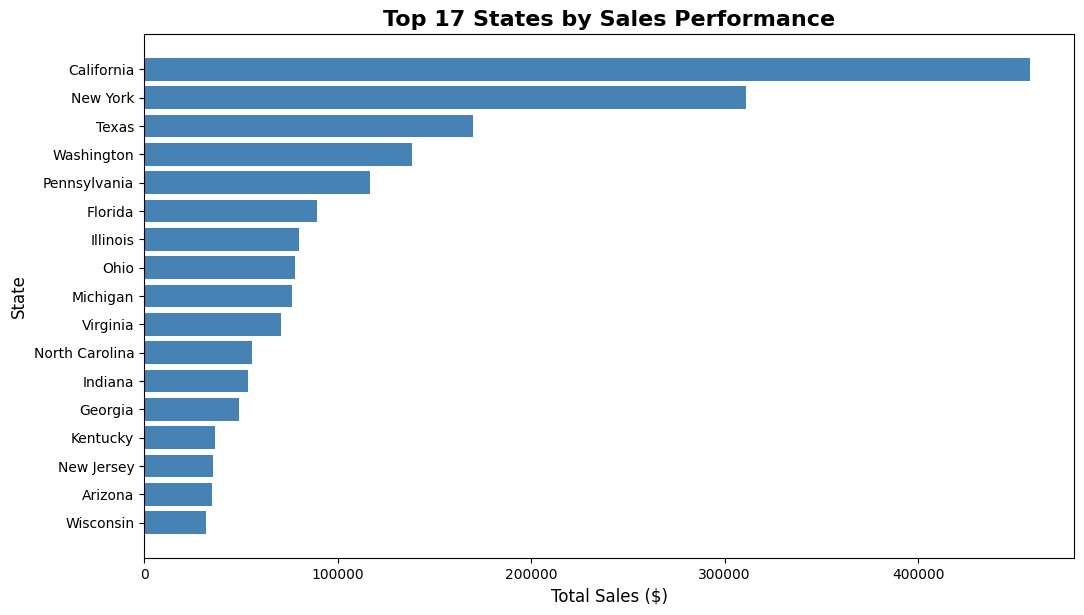

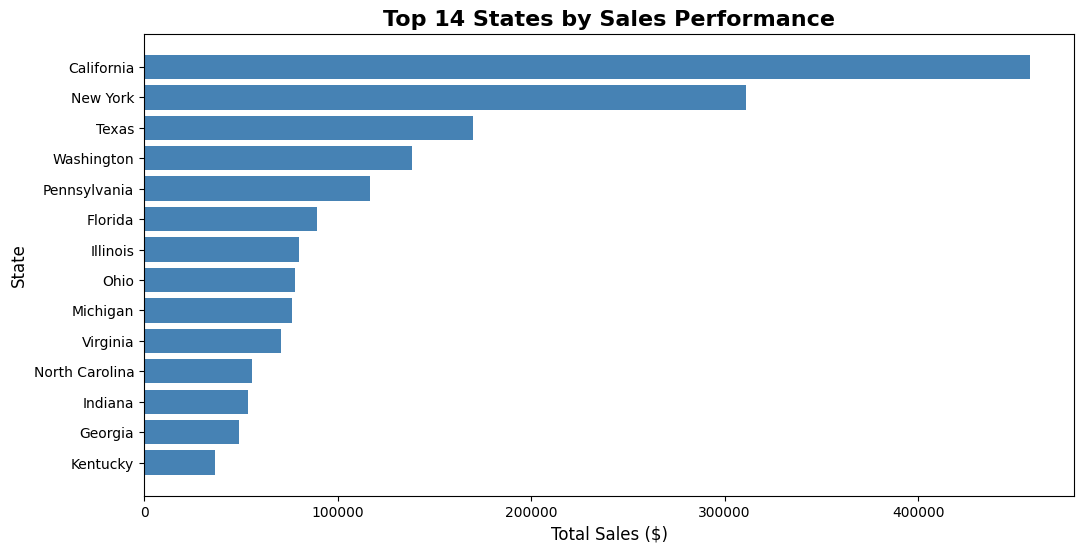

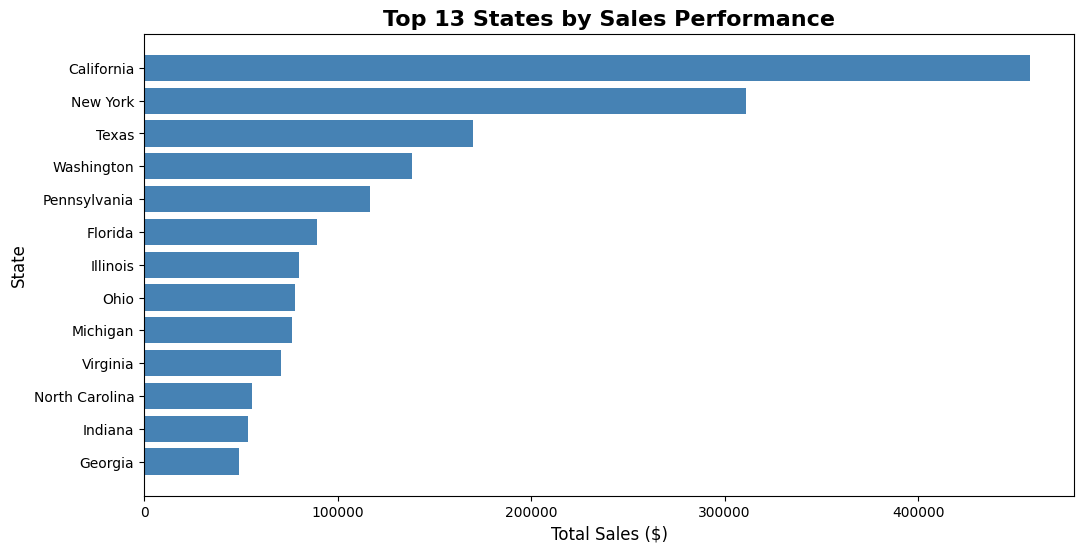

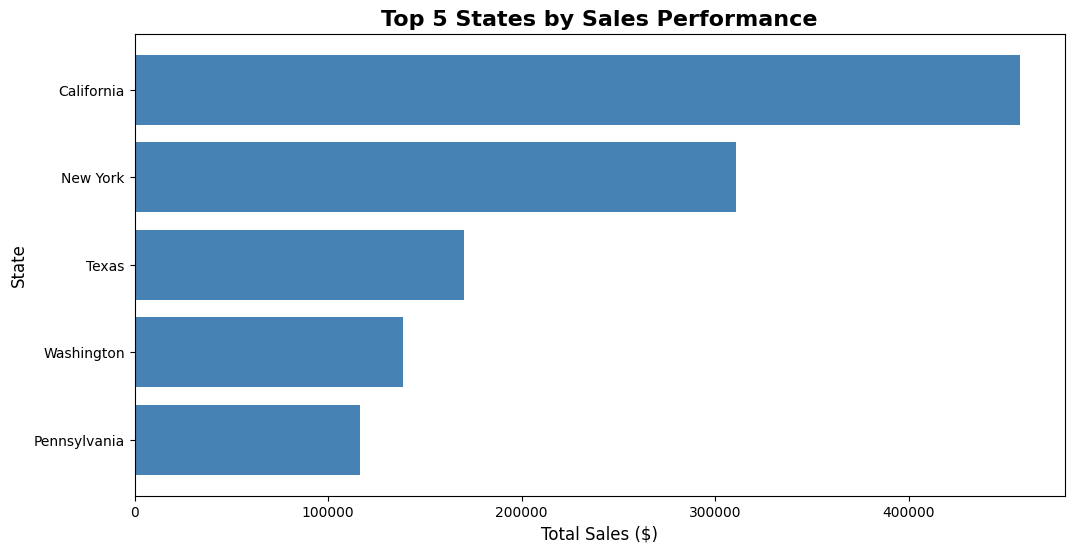

In [10]:
# Prepare geographic sales data
state_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=True)

# Interactive geographic analysis
def plot_top_states(top_n=10):
    plt.figure(figsize=(12, max(6, top_n * 0.4)))

    # Get top N states
    top_states = state_sales.tail(top_n)

    # Create horizontal bar chart
    bars = plt.barh(range(len(top_states)), top_states.values, color='steelblue')
    plt.yticks(range(len(top_states)), top_states.index)
    plt.xlabel('Total Sales ($)', fontsize=12)
    plt.ylabel('State', fontsize=12)
    plt.title(f'Top {top_n} States by Sales Performance', fontsize=16, fontweight='bold')

    # Add value labels on bars
    for i, (state, value) in enumerate(top_states.items()):
        plt.text(value + max(top_states.values()) * 0.01, i, f'${value:,.0f}',
                va='center', fontsize=10)

    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Total states analyzed: {len(state_sales)}")
    print(f"Top {top_n} states represent: ${top_states.sum():,.0f} in sales")

# Create interactive slider
top_n_slider = IntSlider(min=5, max=25, value=10, description='Top N States:')
interact(plot_top_states, top_n=top_n_slider);

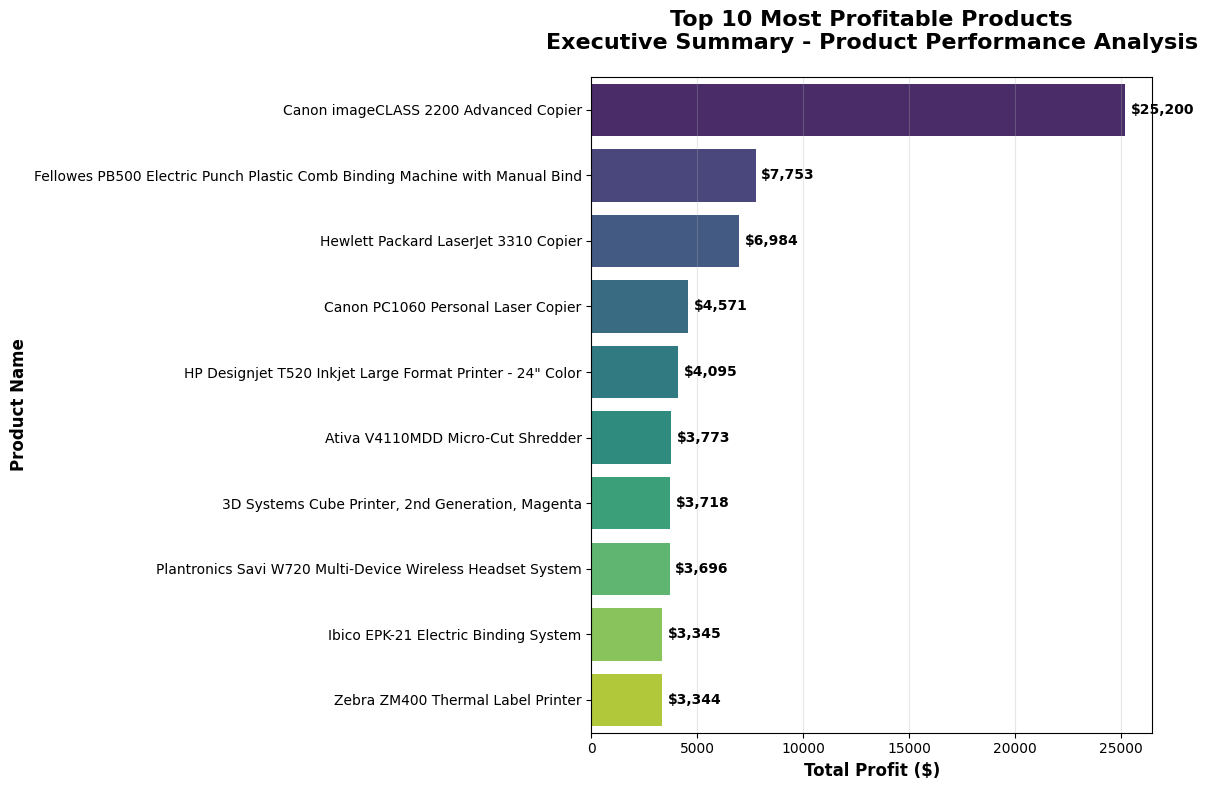

Key Insights:
• Most profitable product generates: $25,200
• Top 10 products contribute: $66,479 total profit
• Average profit per top product: $6,648


In [13]:
# Analyze top profitable products
product_profit = df.groupby('Product Name')['Profit'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=product_profit.values, y=product_profit.index,
                  palette='viridis', orient='h')

# Customize the plot
plt.title('Top 10 Most Profitable Products\nExecutive Summary - Product Performance Analysis',
            fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Total Profit ($)', fontsize=12, fontweight='bold')
plt.ylabel('Product Name', fontsize=12, fontweight='bold')

# Add value annotations
for i, (product, profit) in enumerate(product_profit.items()):
    ax.text(profit + max(product_profit.values) * 0.01, i, f'${profit:,.0f}',
            va='center', fontweight='bold', fontsize=10)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Key Insights:")
print(f"• Most profitable product generates: ${product_profit.iloc[0]:,.0f}")
print(f"• Top 10 products contribute: ${product_profit.sum():,.0f} total profit")
print(f"• Average profit per top product: ${product_profit.mean():,.0f}")

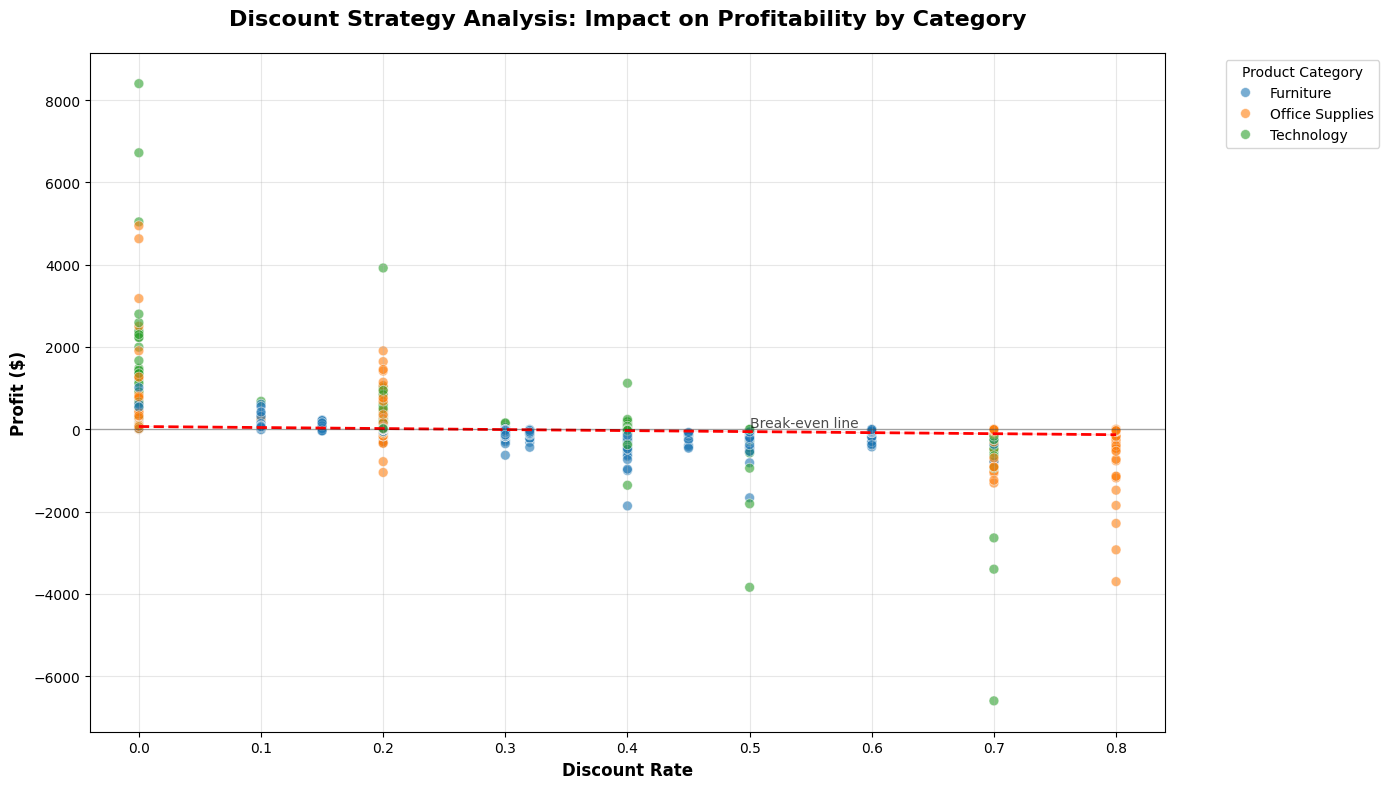

Discount Analysis Insights:
• Transactions with >20% discount: 1,393
• Average profit for high discounts: $-97.18
• Percentage of high-discount sales with losses: 96.8%

Category-specific discount impact:
• Furniture: Average profit at >20% discount = $-100.51
• Office Supplies: Average profit at >20% discount = $-69.32
• Technology: Average profit at >20% discount = $-197.42


In [15]:
# Discount vs Profit Analysis
plt.figure(figsize=(14, 8))

# Create the scatter plot with category colors
sns.scatterplot(data=df, x='Discount', y='Profit', hue='Category',
               alpha=0.6, s=50)

# Add regression line for overall trend
sns.regplot(data=df, x='Discount', y='Profit', scatter=False,
           color='red', line_kws={'linewidth': 2, 'linestyle': '--'})

# Customize the plot
plt.title('Discount Strategy Analysis: Impact on Profitability by Category',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Discount Rate', fontsize=12, fontweight='bold')
plt.ylabel('Profit ($)', fontsize=12, fontweight='bold')

# Add horizontal line at profit = 0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
plt.text(0.5, 50, 'Break-even line', fontsize=10, alpha=0.7)

plt.grid(True, alpha=0.3)
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Analytical insights
print("Discount Analysis Insights:")
high_discount = df[df['Discount'] > 0.2]  # Discounts above 20%
print(f"• Transactions with >20% discount: {len(high_discount):,}")
print(f"• Average profit for high discounts: ${high_discount['Profit'].mean():.2f}")
print(f"• Percentage of high-discount sales with losses: {(high_discount['Profit'] < 0).mean()*100:.1f}%")

# Category-specific analysis
print("\nCategory-specific discount impact:")
for category in df['Category'].unique():
    cat_data = df[df['Category'] == category]
    high_disc_cat = cat_data[cat_data['Discount'] > 0.2]
    if len(high_disc_cat) > 0:
        avg_loss = high_disc_cat['Profit'].mean()
        print(f"• {category}: Average profit at >20% discount = ${avg_loss:.2f}")

In [17]:
# Code to demonstrate library comparison
print("=== LIBRARY COMPARISON ANALYSIS ===")
print()

# Matplotlib strengths demonstrated
print("MATPLOTLIB STRENGTHS (from our analysis):")
print("• Fine-grained control over interactive widgets")
print("• Custom annotations and text positioning")
print("• Precise subplot layouts and figure sizing")
print("• Integration with ipywidgets for dynamic updates")
print()

# Seaborn strengths demonstrated
print("SEABORN STRENGTHS (from our analysis):")
print("• Built-in statistical visualizations (regplot)")
print("• Automatic color palettes and legends")
print("• Clean, publication-ready default styling")
print("• Easy categorical data visualization")
print()

print("SPEED COMPARISON:")
import time

# Time a simple matplotlib plot
start = time.time()
plt.figure(figsize=(8, 6))
plt.plot(df.groupby('Order Year')['Sales'].sum())
plt.close()
matplotlib_time = time.time() - start

# Time a seaborn plot
start = time.time()
plt.figure(figsize=(8, 6))
sns.lineplot(data=df.groupby('Order Year')['Sales'].sum().reset_index(),
             x='Order Year', y='Sales')
plt.close()
seaborn_time = time.time() - start

print(f"• Matplotlib basic plot: {matplotlib_time:.4f} seconds")
print(f"• Seaborn equivalent: {seaborn_time:.4f} seconds")

=== LIBRARY COMPARISON ANALYSIS ===

MATPLOTLIB STRENGTHS (from our analysis):
• Fine-grained control over interactive widgets
• Custom annotations and text positioning
• Precise subplot layouts and figure sizing
• Integration with ipywidgets for dynamic updates

SEABORN STRENGTHS (from our analysis):
• Built-in statistical visualizations (regplot)
• Automatic color palettes and legends
• Clean, publication-ready default styling
• Easy categorical data visualization

SPEED COMPARISON:
• Matplotlib basic plot: 0.0097 seconds
• Seaborn equivalent: 0.0368 seconds


In [18]:
# Generate automated insights for executive summary
print("=== EXECUTIVE SUMMARY - KEY FINDINGS ===")
print()

# Sales performance metrics
total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()
profit_margin = (total_profit / total_sales) * 100

print(f"📊 BUSINESS PERFORMANCE:")
print(f"• Total Revenue: ${total_sales:,.0f}")
print(f"• Total Profit: ${total_profit:,.0f}")
print(f"• Overall Profit Margin: {profit_margin:.1f}%")
print()

# Geographic insights
top_state = state_sales.index[-1]
top_state_sales = state_sales.iloc[-1]
print(f"🗺️ GEOGRAPHIC PERFORMANCE:")
print(f"• Top performing state: {top_state} (${top_state_sales:,.0f})")
print(f"• Geographic concentration: Top 5 states = {(state_sales.tail(5).sum()/total_sales)*100:.1f}% of sales")
print()

# Product insights
top_category = df.groupby('Category')['Sales'].sum().sort_values(ascending=False).index[0]
print(f"🏆 PRODUCT PERFORMANCE:")
print(f"• Leading category: {top_category}")
print(f"• Most profitable product: {product_profit.index[0]}")
print()

# Discount insights
high_discount_loss_rate = (df[df['Discount'] > 0.2]['Profit'] < 0).mean() * 100
print(f"💰 DISCOUNT STRATEGY INSIGHTS:")
print(f"• High discount risk: {high_discount_loss_rate:.1f}% of >20% discounts result in losses")
print(f"• Recommended max discount threshold: 20% to maintain profitability")

=== EXECUTIVE SUMMARY - KEY FINDINGS ===

📊 BUSINESS PERFORMANCE:
• Total Revenue: $2,297,201
• Total Profit: $286,397
• Overall Profit Margin: 12.5%

🗺️ GEOGRAPHIC PERFORMANCE:
• Top performing state: California ($457,688)
• Geographic concentration: Top 5 states = 52.0% of sales

🏆 PRODUCT PERFORMANCE:
• Leading category: Technology
• Most profitable product: Canon imageCLASS 2200 Advanced Copier

💰 DISCOUNT STRATEGY INSIGHTS:
• High discount risk: 96.8% of >20% discounts result in losses
• Recommended max discount threshold: 20% to maintain profitability


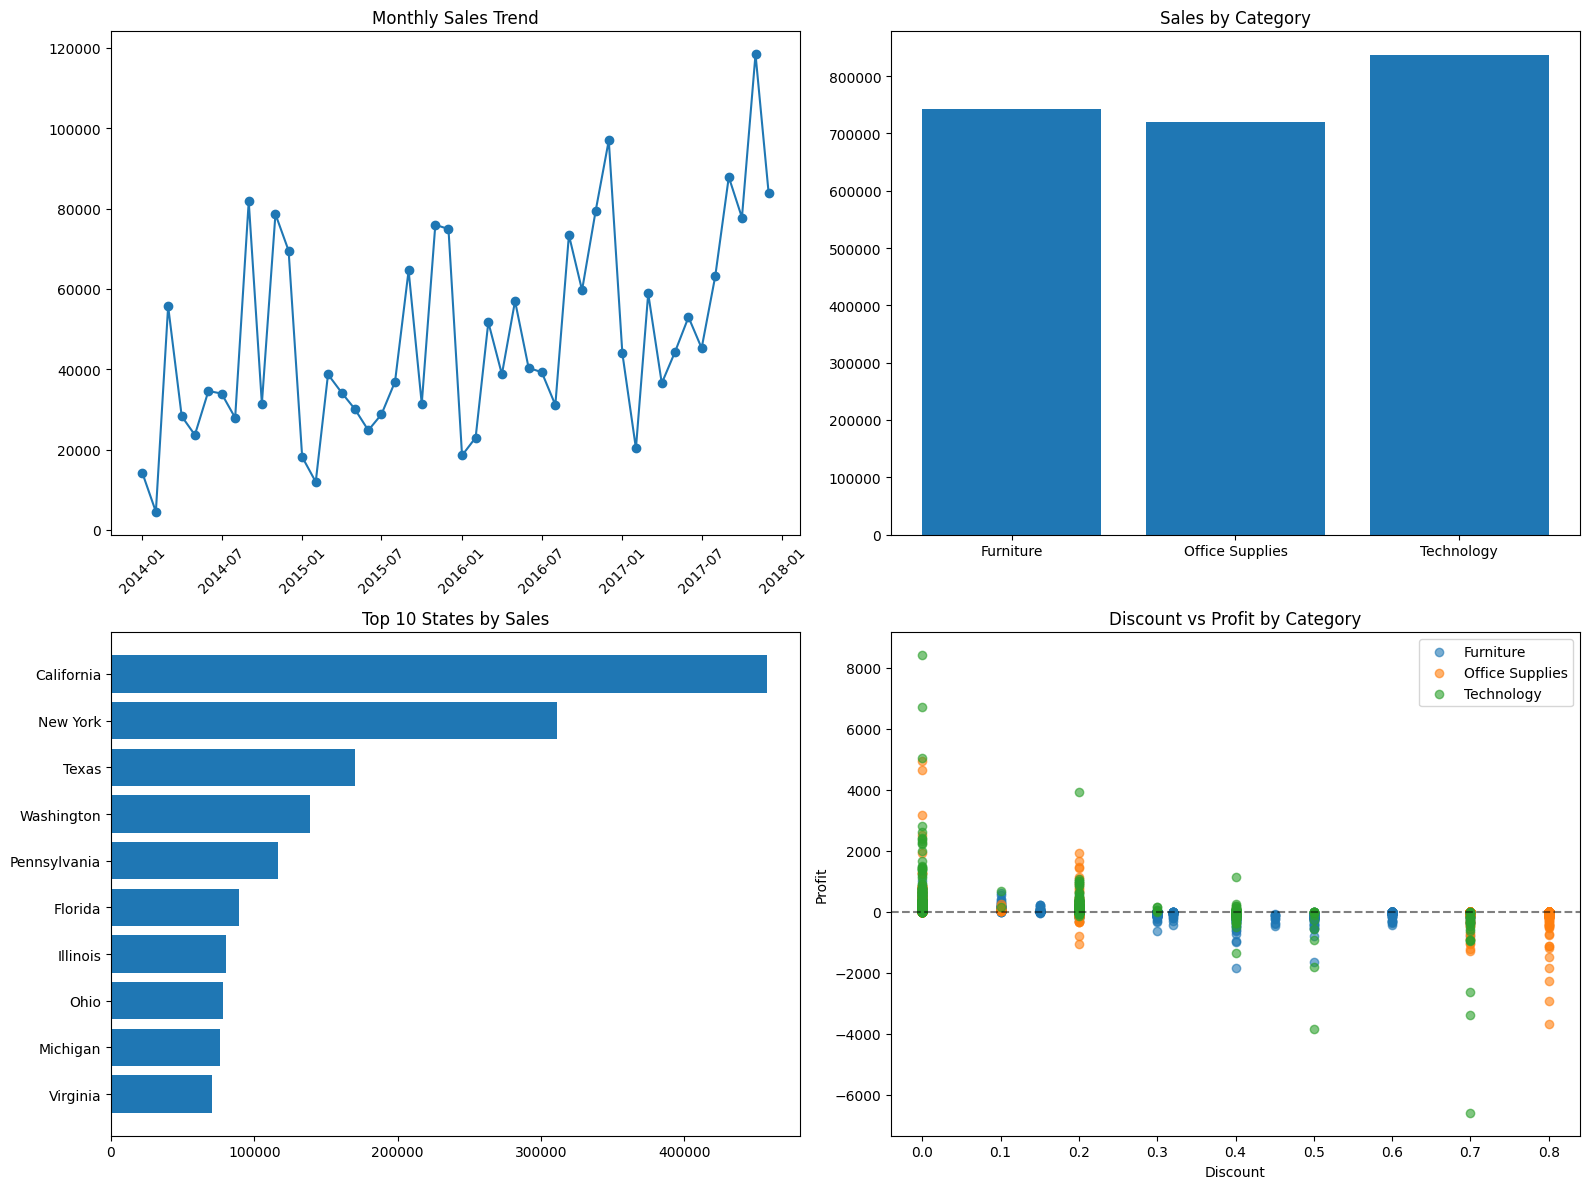

In [19]:
# Advanced: Multi-chart dashboard
def create_dashboard():
    # Create subplot layout
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Chart 1: Monthly sales trend
    monthly_total = df.groupby('Order Month-Year')['Sales'].sum()
    ax1.plot(monthly_total.index.to_timestamp(), monthly_total.values, marker='o')
    ax1.set_title('Monthly Sales Trend')
    ax1.tick_params(axis='x', rotation=45)

    # Chart 2: Category performance
    category_sales = df.groupby('Category')['Sales'].sum()
    ax2.bar(category_sales.index, category_sales.values)
    ax2.set_title('Sales by Category')

    # Chart 3: State performance (top 10)
    top_10_states = state_sales.tail(10)
    ax3.barh(range(len(top_10_states)), top_10_states.values)
    ax3.set_yticks(range(len(top_10_states)))
    ax3.set_yticklabels(top_10_states.index)
    ax3.set_title('Top 10 States by Sales')

    # Chart 4: Discount vs Profit
    for category in df['Category'].unique():
        cat_data = df[df['Category'] == category]
        ax4.scatter(cat_data['Discount'], cat_data['Profit'],
                   label=category, alpha=0.6)
    ax4.set_xlabel('Discount')
    ax4.set_ylabel('Profit')
    ax4.set_title('Discount vs Profit by Category')
    ax4.legend()
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Call the dashboard function
create_dashboard()

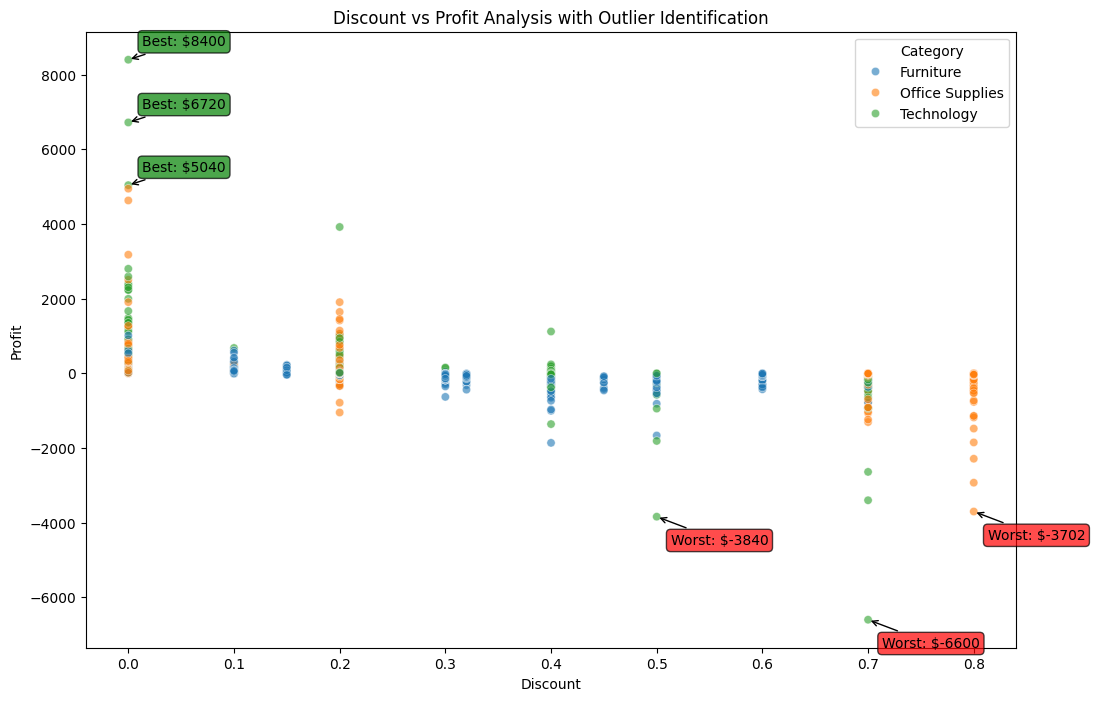

In [21]:
# Advanced: Outlier analysis with annotations
plt.figure(figsize=(12, 8))

# Create base scatter plot
sns.scatterplot(data=df, x='Discount', y='Profit', hue='Category', alpha=0.6)

# Identify and annotate outliers
top_3_profitable = df.nlargest(3, 'Profit')
bottom_3_profitable = df.nsmallest(3, 'Profit')

# Annotate top performers
for idx, row in top_3_profitable.iterrows():
    plt.annotate(f'Best: ${row["Profit"]:.0f}',
                xy=(row['Discount'], row['Profit']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Annotate worst performers
for idx, row in bottom_3_profitable.iterrows():
    plt.annotate(f'Worst: ${row["Profit"]:.0f}',
                xy=(row['Discount'], row['Profit']),
                xytext=(10, -20), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.title('Discount vs Profit Analysis with Outlier Identification')
plt.show()